In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import TimeSeriesSplit

In [0]:
# fundq = pd.read_csv('/gdrive/My Drive/data/dl-project/repository/fundq.zip', compression='zip', parse_dates=[0], index_col=[0, 1])
fundq = pd.read_csv('/gdrive/My Drive/data/fundq.zip', compression='zip', parse_dates=[0], index_col=[0, 1])
fundq = fundq[fundq['TICKER'].notnull()]

In [0]:
fundq.head()

TICKER   CAPEI     bm     evm  pe_op_basic  pe_op_dil  \
date       PERMNO                                                         
1970-01-30 10102      AN   7.889  0.790   8.730          NaN        NaN   
           10137     AYP  11.110  0.630   9.757          NaN        NaN   
           10145     ACD   9.049  0.744   7.378          NaN        NaN   
           10161     AMX  13.710  0.581  12.373          NaN        NaN   
           10225     AMB  10.152  0.709   6.552          NaN        NaN   

                   pe_exi  pe_inc     ps     pcf  ...  PEG_trailing  DIVYIELD  \
date       PERMNO                                 ...                           
1970-01-30 10102   10.692  10.692  0.396   4.095  ...           NaN    0.0471   
           10137    5.039  10.132  1.628   5.225  ...         0.891    0.0686   
           10145   16.096  36.719  0.492   3.650  ...           NaN    0.0511   
           10161   11.552  10.614  1.142  16.207  ...         0.503    0.0412   
           10225    9.199   9.199  0.336  -7.256  ...         1.111    0.0611   

                      VOL   SHROUT    MKTCAP    PRC       RET  RET_shifted  \
date       PERMNO                                                            
1970-01-30 10102   1960.0  11036.0  187612.0  17.00  0.038168     0.004412   
           10137   1422.0  20792.0  400246.0  19.25 -0.066667     0.123377   
           10145   3088.0  27745.0  652007.5  23.50 -0.035897     0.012766   
           10161   1851.0  23652.0  804168.0  34.00 -0.062069     0.183088   
           10225   2921.0  27038.0  885494.5  32.75 -0.083916     0.016031   

                   pct_rank  label  
date       PERMNO                   
1970-01-30 10102   0.215649      0  
           10137   0.778626      1  
           10145   0.246183      0  
           10161   0.944656      1  
           10225   0.253817      0  

[5 rows x 78 columns]

In [0]:
def add_momentum(group):
    for i in range(1, 12):
        group.insert(len(group.columns)-(i+3), f'RET-{i}', group['RET'].shift(i))
    return group

In [0]:
fundq_mom = fundq.groupby('PERMNO').apply(add_momentum)

In [0]:
features = fundq_mom.columns[1:-3]
# features

In [0]:
def normalize_features(group):
#     group[features.tolist()] = group[features.tolist()].apply(winsor, axis=0).copy()
    group[features.tolist()] = ((group[features.tolist()] - group[features.tolist()].mean()) / group[features.tolist()].std()).values
    return group

In [0]:
df = fundq_mom.groupby(level=0).apply(normalize_features)

In [0]:
training_set = df.loc[:'2012-12-31']
testing_set = df.loc['2013-1-31':]

In [0]:
train_dates = training_set.index.get_level_values('date').unique()
test_dates = testing_set.index.get_level_values('date').unique()

In [0]:
def process(group):
    return group.iloc[0, :]

In [0]:
newdf = training_set.groupby('date').apply(process)

## Set up Time Series CV Folds

In [0]:
def rolling_window_split(df):
    # 5-1 train/test split, 5 folds
    fold_size = np.floor(len(df) / 10).astype(int)
    for i in range(5):
        if i != 4:
            yield (list(range(i*fold_size, (i+5)*fold_size-3)),
                   list(range((i+5)*fold_size+3, (i+6)*fold_size)))
        if i == 4:
            yield (list(range(i*fold_size, (i+5)*fold_size-3)),
                   list(range((i+5)*fold_size+3, len(df))))

In [0]:
for i, (train_index, test_index) in enumerate(rolling_window_split(newdf)):
    print('train {} length:'.format(i+1), len(train_index))
    print('train {}: '.format(i+1), [train_dates[train_index[0]].strftime('%Y-%m-%d'), 
                                     train_dates[train_index[-1]].strftime('%Y-%m-%d')])
    print('test {} length:'.format(i+1),len(test_index))
    print('test {}:'.format(i+1), [train_dates[test_index[0]].strftime('%Y-%m-%d'), 
                                   train_dates[test_index[-1]].strftime('%Y-%m-%d')])

train 1 length: 252
train 1:  ['1970-01-30', '1990-12-31']
test 1 length: 48
test 1: ['1991-07-31', '1995-06-30']
train 2 length: 252
train 2:  ['1974-04-30', '1995-03-31']
test 2 length: 48
test 2: ['1995-10-31', '1999-09-30']
train 3 length: 252
train 3:  ['1978-07-31', '1999-06-30']
test 3 length: 48
test 3: ['2000-01-31', '2003-12-31']
train 4 length: 252
train 4:  ['1982-10-29', '2003-09-30']
test 4 length: 48
test 4: ['2004-04-30', '2008-03-31']
train 5 length: 252
train 5:  ['1987-01-30', '2007-12-31']
test 5 length: 54
test 5: ['2008-07-31', '2012-12-31']


In [0]:
fold_5 = training_set.loc[train_dates[train_index[0]].strftime('%Y-%m-%d'):
                          train_dates[train_index[-1]].strftime('%Y-%m-%d')].copy()

In [0]:
X, y = fold_5[features.tolist()].copy(), fold_5['label'].copy()
X.fillna(0, inplace=True)
X = X.reset_index(level=1)
X['PERMNO'] = X['PERMNO'].astype('category')

In [0]:
fold_5_val = training_set.loc[train_dates[test_index[0]].strftime('%Y-%m-%d'):
                              train_dates[test_index[-1]].strftime('%Y-%m-%d')].copy()
X_val, y_val = fold_5_val[features.tolist()].copy(), fold_5_val['label'].copy()
X_val.fillna(0, inplace=True)
X_val = X_val.reset_index(level=1)
X_val['PERMNO'] = X_val['PERMNO'].astype('category')

X_test, y_test = testing_set[features.tolist()].copy(), testing_set['label'].copy()
X_test.fillna(0, inplace=True)
X_test = X_test.reset_index(level=1)
X_test['PERMNO'] = X_test['PERMNO'].astype('category')

In [0]:
X.head()

PERMNO        CAPEI        bm       evm  pe_op_basic  pe_op_dil  \
date                                                                         
1987-01-30  10016    -0.067871  0.701211 -0.082761 -9999.000000    -9999.0   
1987-01-30  10071 -9999.000000 -0.362599 -0.009336 -9999.000000    -9999.0   
1987-01-30  10078 -9999.000000 -0.882305  0.020241    -0.269772    -9999.0   
1987-01-30  10104 -9999.000000 -1.338572  0.049819 -9999.000000    -9999.0   
1987-01-30  10107 -9999.000000 -1.189736 -0.129968    -0.300763    -9999.0   

              pe_exi    pe_inc        ps       pcf  ...   RET-9        RET-8  \
date                                                ...                        
1987-01-30 -0.208937 -0.168939 -0.404545 -0.033903  ... -9999.0 -9999.000000   
1987-01-30 -0.127232 -0.072672 -0.100316 -0.528356  ... -9999.0 -9999.000000   
1987-01-30  0.453060  0.611046  0.453605  0.492225  ... -9999.0     0.746688   
1987-01-30  0.634157  0.824421  0.775227  6.067141  ... -9999.0 -9999.000000   
1987-01-30  0.377850  0.522431  1.936720  0.518627  ... -9999.0     0.332336   

                  RET-7        RET-6        RET-5        RET-4        RET-3  \
date                                                                          
1987-01-30 -9999.000000 -9999.000000 -9999.000000 -9999.000000 -9999.000000   
1987-01-30     0.337409    -0.183838    -1.276402    -0.676012    -0.135660   
1987-01-30    -1.510126     0.149271    -1.579668     0.688452     3.359602   
1987-01-30 -9999.000000 -9999.000000 -9999.000000     0.067861    -0.137336   
1987-01-30    -1.476816    -0.190954    -0.747844     0.689399     3.623486   

                  RET-2     RET-1       RET  
date                                         
1987-01-30 -9999.000000  0.517379  1.316948  
1987-01-30     1.617490 -0.318410  1.190638  
1987-01-30     1.973415  1.706847 -0.002610  
1987-01-30     2.682112 -0.185535  1.534095  
1987-01-30     3.982172 -0.123641  3.520823  

[5 rows x 86 columns]

In [0]:
! pip install catboost; pip install ipywidgets; pip install shap; jupyter nbextension enable --py widgetsnbextension; pip install -q hyperopt frozendict; pip install graphviz; pip install pydotplus

     |████████████████████████████████| 60.6MB 51.4MB/s 
     |████████████████████████████████| 225kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
from catboost import CatBoost, Pool
train_pool = Pool(
    data=X,
    label=y,
    cat_features = [0],
    group_id=X.index.strftime('%Y-%m-%d').tolist()
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features = [0],
    group_id=X_val.index.strftime('%Y-%m-%d').tolist()
)

test_pool = Pool(
    data=X_test,
    cat_features = [0],
    group_id=X_test.index.strftime('%Y-%m-%d').tolist()
)

In [0]:
from copy import deepcopy
default_parameters = {
    'iterations': 2000,
#     'custom_metric': ['Accuracy'],
    'use_best_model': False,
#     'od_type': 'IncToDec',
#     'od_pval': 5e-3,
    'random_seed': 0
}

parameters = {}
def fit_model(loss_function, additional_params=None, train_pool=train_pool, val_pool=val_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoost(parameters)
    model.fit(train_pool, eval_set=val_pool, verbose=10, plot=True)
    return model

In [0]:
from catboost import CatBoost
clf = fit_model('QueryRMSE', {'iterations': 1000, 'task_type': 'GPU'})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7529780	test: 0.7263596	best: 0.7263596 (0)	total: 30.9ms	remaining: 30.9s
10:	learn: 0.7513497	test: 0.7251329	best: 0.7251329 (10)	total: 328ms	remaining: 29.5s
20:	learn: 0.7502642	test: 0.7246709	best: 0.7246709 (20)	total: 563ms	remaining: 26.2s
30:	learn: 0.7494528	test: 0.7245167	best: 0.7245167 (30)	total: 770ms	remaining: 24.1s
40:	learn: 0.7488212	test: 0.7246690	best: 0.7245167 (30)	total: 967ms	remaining: 22.6s
50:	learn: 0.7482984	test: 0.7247610	best: 0.7245167 (30)	total: 1.16s	remaining: 21.6s
60:	learn: 0.7477737	test: 0.7247792	best: 0.7245167 (30)	total: 1.38s	remaining: 21.3s
70:	learn: 0.7474363	test: 0.7247741	best: 0.7245167 (30)	total: 1.6s	remaining: 20.9s
80:	learn: 0.7470477	test: 0.7247455	best: 0.7245167 (30)	total: 1.81s	remaining: 20.6s
90:	learn: 0.7466900	test: 0.7249387	best: 0.7245167 (30)	total: 2.03s	remaining: 20.3s
100:	learn: 0.7463153	test: 0.7249430	best: 0.7245167 (30)	total: 2.23s	r

In [0]:
X_test.head()

PERMNO     CAPEI        bm       evm  pe_op_basic  pe_op_dil  \
date                                                                      
2013-01-31  10104  0.009475 -0.594942 -0.052706     0.030233   0.020665   
2013-01-31  10107 -0.082512 -0.590753 -0.056511    -0.064515  -0.074384   
2013-01-31  10138  0.062127 -0.682911 -0.032144     0.111146   0.106164   
2013-01-31  10145  0.007419 -0.565619 -0.031948     0.107245   0.097094   
2013-01-31  10147  0.063061 -0.379209 -0.042200     0.063843   0.068844   

              pe_exi    pe_inc        ps       pcf  ...     RET-9     RET-8  \
date                                                ...                       
2013-01-31 -0.070919 -0.071558  0.201514 -0.067936  ...  0.180831 -0.433581   
2013-01-31 -0.098438 -0.099147  0.041314 -0.254300  ... -0.062415 -0.234991   
2013-01-31  0.008184  0.007747  0.416670  0.246833  ... -0.419415 -0.297332   
2013-01-31  0.017583  0.017169 -0.168813  0.013217  ... -0.047967 -0.170839   
2013-01-31 -0.021666 -0.022180 -0.047166 -0.230855  ... -0.727146 -1.050644   

               RET-7     RET-6     RET-5     RET-4     RET-3     RET-2  \
date                                                                     
2013-01-31  1.228836  0.136205  0.147103 -0.565893 -0.110482  0.196894   
2013-01-31  0.256982 -0.522436  0.205448 -1.025510 -0.476787 -1.084640   
2013-01-31  0.928657 -0.504494 -0.319542  0.110986  0.307032 -0.324119   
2013-01-31 -0.329938  0.382263 -0.294717 -0.108640  0.306758 -0.169694   
2013-01-31  0.606959  0.181030 -0.425283  0.134784 -1.231609 -0.058432   

               RET-1       RET  
date                            
2013-01-31  0.249859 -0.113034  
2013-01-31 -0.327321 -0.653418  
2013-01-31  0.042032  0.326478  
2013-01-31  0.153394  0.021006  
2013-01-31 -0.085223 -1.435226  

[5 rows x 86 columns]

In [0]:
training_losses = np.array(clf.evals_result_['learn']['QueryRMSE'])
validation_losses = np.array(clf.evals_result_['validation_0']['QueryRMSE'])

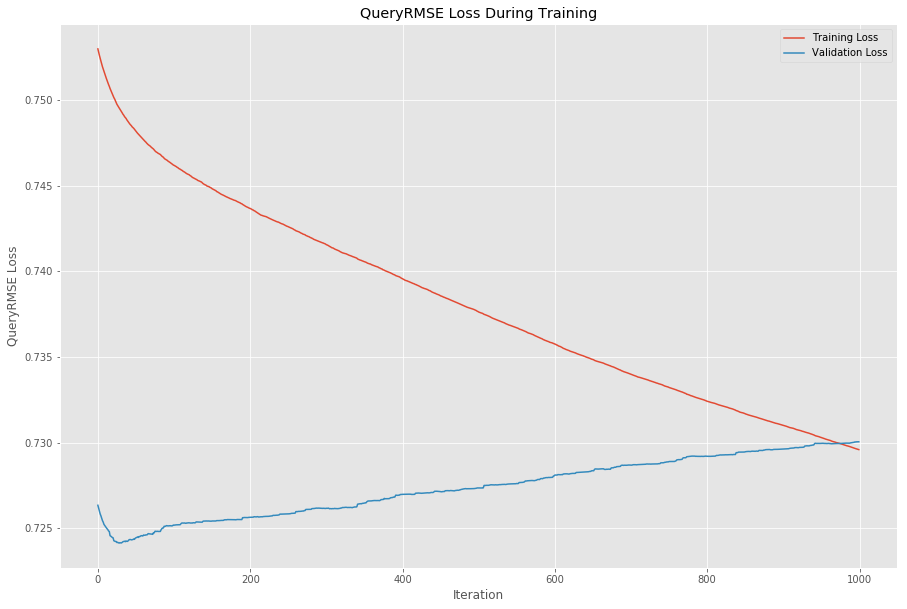

In [0]:
plt.style.use('ggplot')
plt.figure(figsize=(15, 10))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()
plt.title('QueryRMSE Loss During Training')
plt.ylabel('QueryRMSE Loss')
plt.xlabel('Iteration')
plt.show()

### Preprocess Raw DataSet and use pretrained model to predict on test-set, then generate portfolio

In [0]:
from catboost import CatBoost, Pool

## Predict
y_test_hat = clf.predict(test_pool)
y_test_hat = pd.DataFrame(y_test_hat, columns=['score'], index=X_test.index)
y_test_hat.insert(0, 'PERMNO', X_test['PERMNO'])
y_test_hat.insert(2, 'y', y_test.values)

## Generate Portfolio
test_long_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
test_long_portfolio = test_long_portfolio.reset_index(level=1, drop=True)
test_short_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))
test_short_portfolio = test_short_portfolio.reset_index(level=1, drop=True)

In [0]:
test_long_portfolio_copy = test_long_portfolio.copy()
test_long_portfolio_copy = test_long_portfolio_copy.reset_index()
test_long_portfolio_copy = test_long_portfolio_copy.set_index(['date', 'PERMNO'])
testing_returns = pd.DataFrame(testing_set[['TICKER', 'RET_shifted']])
testing_returns = testing_returns.reset_index(level=1)
testing_returns['PERMNO'] = testing_returns['PERMNO'].astype('category')
test_long_portfolio_merged = pd.merge(test_long_portfolio_copy, testing_returns, how='left', on=['date', 'PERMNO'])
test_long_portfolio_merged = test_long_portfolio_merged[['PERMNO', 'TICKER', 'RET_shifted']]
test_long_portfolio_merged = test_long_portfolio_merged.reset_index()
test_long_portfolio_merged = test_long_portfolio_merged.set_index(['date', 'PERMNO'])

In [0]:
test_short_portfolio_copy = test_short_portfolio.copy()
test_short_portfolio_copy = test_short_portfolio_copy.reset_index()
test_short_portfolio_copy = test_short_portfolio_copy.set_index(['date', 'PERMNO'])
test_short_portfolio_merged = pd.merge(test_short_portfolio_copy, testing_returns, how='left', on=['date', 'PERMNO'])
test_short_portfolio_merged = test_short_portfolio_merged[['PERMNO', 'TICKER', 'RET_shifted']]
test_short_portfolio_merged = test_short_portfolio_merged.reset_index()
test_short_portfolio_merged = test_short_portfolio_merged.set_index(['date', 'PERMNO'])

In [0]:
test_portfolio_sets = pd.DataFrame(test_long_portfolio_merged.groupby(level=0).apply(lambda x: set(x.index.get_level_values(1))), columns=['set'])
test_portfolio_sets['set_shifted'] = test_portfolio_sets['set'].shift()
test_portfolio_sets = test_portfolio_sets.dropna()
test_portfolio_sets.loc[:, 'turnover'] = test_portfolio_sets.copy().apply(lambda x: len(set(x.set).difference(set(x.set_shifted)))/100, axis=1)

test_short_portfolio_sets = pd.DataFrame(test_short_portfolio_merged.groupby(level=0).apply(lambda x: set(x.index.get_level_values(1))), columns=['set'])
test_short_portfolio_sets['set_shifted'] = test_short_portfolio_sets['set'].shift()
test_short_portfolio_sets = test_short_portfolio_sets.dropna()
test_short_portfolio_sets.loc[:, 'turnover'] = test_short_portfolio_sets.copy().apply(lambda x: len(set(x.set).difference(set(x.set_shifted)))/100, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


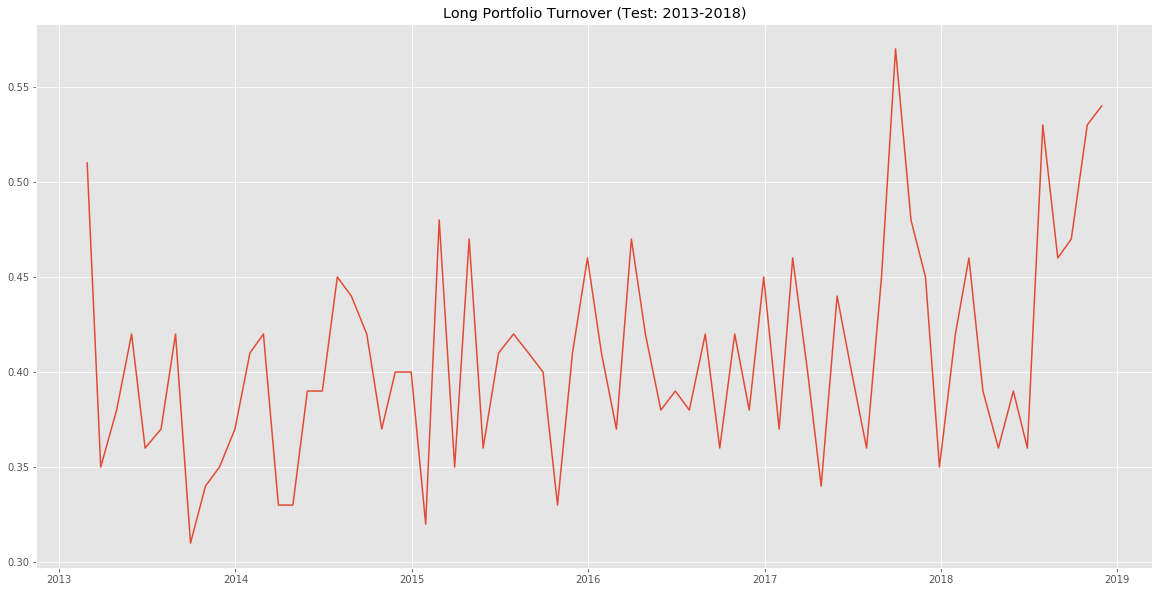

In [0]:
plt.figure(figsize=(20,10))
plt.plot(test_portfolio_sets['turnover'])
plt.title("Long Portfolio Turnover (Test: 2013-2018)")
plt.show()

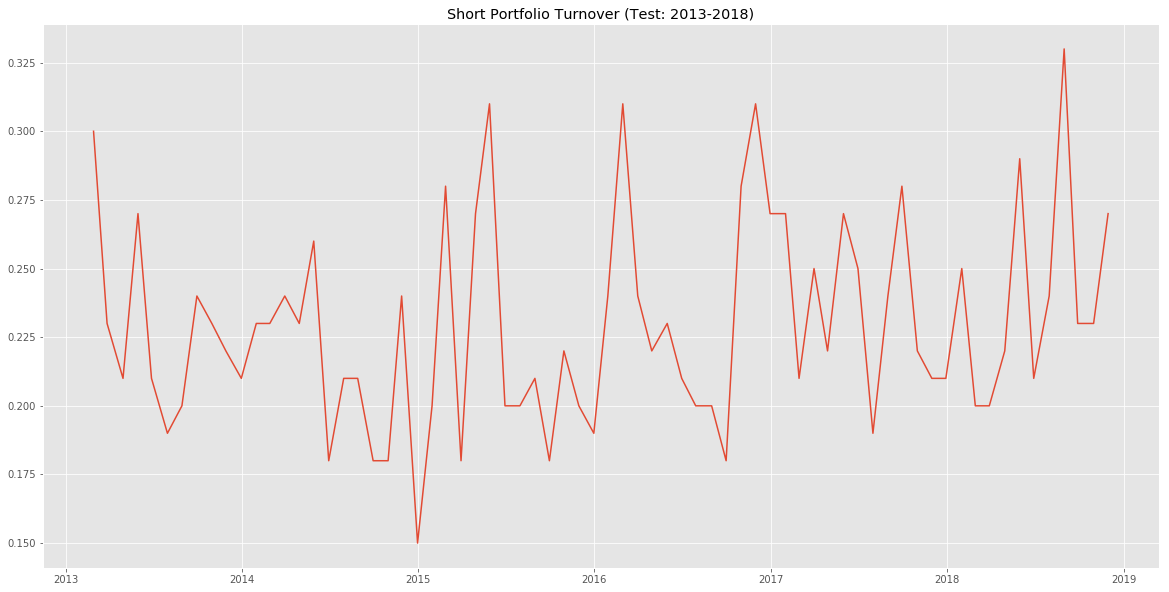

In [0]:
plt.figure(figsize=(20,10))
plt.plot(test_short_portfolio_sets['turnover'])
plt.title("Short Portfolio Turnover (Test: 2013-2018)")
plt.show()

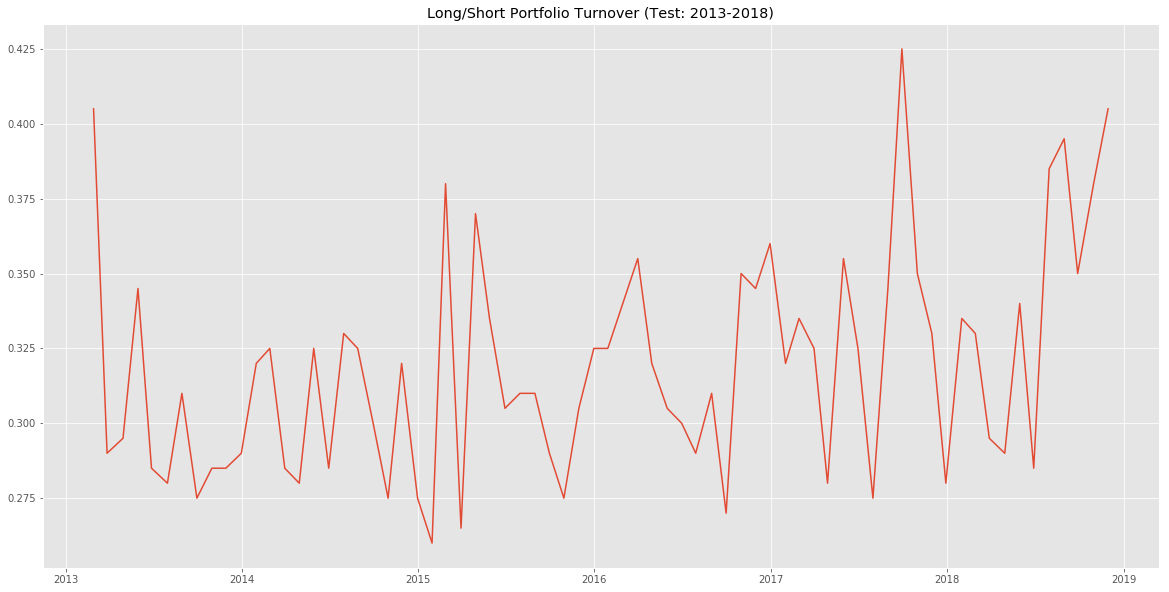

In [0]:
plt.figure(figsize=(20,10))
plt.plot((test_short_portfolio_sets['turnover']+test_portfolio_sets['turnover'])/2)
plt.title("Long/Short Portfolio Turnover (Test: 2013-2018)")
plt.show()

In [0]:
test_long_portfolio_merged.head()

TICKER  RET_shifted
date       PERMNO                    
2013-01-31 81138    APOL    -0.165677
           47941     GCI     0.022415
           24459     PBI    -0.064885
           78840    IACI    -0.006303
           53225     WPO     0.033344

In [0]:
test_long_return = pd.DataFrame(test_long_portfolio_merged.groupby(level=0)['RET_shifted'].mean())
test_short_return = -pd.DataFrame(test_short_portfolio_merged.groupby(level=0)['RET_shifted'].mean())

In [0]:
test_long_return.head()

RET_shifted
date                   
2013-01-31     0.012122
2013-02-28     0.047687
2013-03-28     0.018126
2013-04-30     0.051818
2013-05-31    -0.013919

In [0]:
test_long_short_return = (test_long_return+test_short_return) / 2

In [0]:
test_long_short_return.mean()*np.sqrt(12) / test_long_short_return.std()

RET_shifted    0.246692
dtype: float64

In [0]:
test_long_return.loc[pd.to_datetime('2018-12-31')] = np.nan
test_long_return['return'] = test_long_return['RET_shifted'].shift()
test_long_return = test_long_return[['return']]

test_short_return.loc[pd.to_datetime('2018-12-31')] = np.nan
test_short_return['return'] = test_short_return['RET_shifted'].shift()
test_short_return = test_short_return[['return']]

In [0]:
sp500 = pd.read_csv('/gdrive/My Drive/data/dl-project/repository/sp500.csv', parse_dates=[0], usecols=['Date', 'Adj Close'])
sp500.columns = ['date', 'price']
sp500 = sp500.set_index('date')
long_sp500_merged = pd.merge(test_long_return, sp500, how='left', on='date')
long_sp500_merged['sp500_return'] = long_sp500_merged['price'].pct_change()
long_sp500_merged = long_sp500_merged[['return', 'sp500_return']]
long_sp500_merged = long_sp500_merged.dropna()

short_sp500_merged = pd.merge(test_short_return, sp500, how='left', on='date')
short_sp500_merged['sp500_return'] = short_sp500_merged['price'].pct_change()
short_sp500_merged = short_sp500_merged[['return', 'sp500_return']]
short_sp500_merged = short_sp500_merged.dropna()

In [0]:
long_short_sp500_merged = (long_sp500_merged+short_sp500_merged)/2
long_short_sp500_merged.head()

return  sp500_return
date                              
2013-02-28  0.011297      0.011061
2013-03-28  0.008164      0.035988
2013-04-30  0.007869      0.018086
2013-05-31  0.014272      0.020763
2013-06-28  0.002977     -0.014999

In [0]:
long_sp500_merged['Active Return'] = long_sp500_merged['return'] - long_sp500_merged['sp500_return']
short_sp500_merged['Active Return'] = short_sp500_merged['return'] - short_sp500_merged['sp500_return']
long_short_sp500_merged['Active Return'] = long_short_sp500_merged['return'] - long_short_sp500_merged['sp500_return']
test_long_ir = np.sqrt(12) * long_sp500_merged['Active Return'].mean() / long_sp500_merged['Active Return'].std()
test_long_ir

0.7000949212695651

In [0]:
test_long_sr = np.sqrt(12) * long_sp500_merged['return'].mean() / long_sp500_merged['return'].std()
test_long_sr

3.0291947088289604

In [0]:
test_long_short_ir = np.sqrt(12) * long_short_sp500_merged['Active Return'].mean() / long_short_sp500_merged['Active Return'].std()
test_long_short_ir

-0.9581949378104678

In [0]:
test_long_short_sr = np.sqrt(12) * long_short_sp500_merged['return'].mean() / long_short_sp500_merged['return'].std()
test_long_short_sr

-0.3057659157751221

In [0]:
test_monthly_long_return = long_sp500_merged['return']
test_monthly_short_return = short_sp500_merged['return']
test_monthly_long_short_return = long_short_sp500_merged['return']
test_sp500_return = long_sp500_merged['sp500_return']

In [0]:
test_long_mean = (test_monthly_long_return.values).mean()
test_short_mean = (test_monthly_short_return.values).mean()
test_long_short_mean = (test_monthly_long_short_return.values).mean()
test_sp500_mean = (test_sp500_return.values).mean()
test_long_active_mean = (test_monthly_long_return.values-test_sp500_return.values).mean()
test_short_active_mean = (test_monthly_short_return.values-test_sp500_return.values).mean()
test_long_short_active_mean = (test_monthly_long_short_return.values-test_sp500_return.values).mean()
test_sp500_active_mean = 0
test_long_ir = ((test_monthly_long_return.values-test_sp500_return.values).mean() / (test_monthly_long_return.values-test_sp500_return.values).std()) * np.sqrt(12)
test_short_ir = ((test_monthly_short_return.values-test_sp500_return.values).mean() / (test_monthly_short_return.values-test_sp500_return.values).std()) * np.sqrt(12)
test_long_short_ir = ((test_monthly_long_short_return.values-test_sp500_return.values).mean() / (test_monthly_long_short_return.values-test_sp500_return.values).std()) * np.sqrt(12)
test_sp500_ir = 0
test_long_sr = ((test_monthly_long_return.values).mean() / (test_monthly_long_return.values).std()) * np.sqrt(12)
test_short_sr = ((test_monthly_short_return.values).mean() / (test_monthly_short_return.values).std()) * np.sqrt(12)
test_long_short_sr = ((test_monthly_long_short_return.values).mean() / (test_monthly_long_short_return.values).std()) * np.sqrt(12)
test_sp500_sr = ((test_sp500_return.values).mean() / (test_sp500_return.values).std()) * np.sqrt(12)

In [0]:
test_chart_np = np.array([[test_long_mean, test_long_active_mean, test_long_ir, test_long_sr],
                           [test_short_mean, test_short_active_mean, test_short_ir, test_short_sr],
                           [test_long_short_mean, test_long_short_active_mean, test_long_short_ir, test_long_short_sr], 
                           [test_sp500_mean, test_sp500_active_mean, test_sp500_ir, test_sp500_sr]])
test_chart_df = pd.DataFrame(test_chart_np, columns=['Mean Return', 'Mean Active Return', 'Information Ratio', 'Sharpe Ratio'],
                              index=['long', 'short', 'long/short', 'S&P500'])
print('Testing Set Portfolio Summary Statistics')
test_chart_df

Testing Set Portfolio Summary Statistics


Mean Return  Mean Active Return  Information Ratio  Sharpe Ratio
long           0.033657            0.025912           4.714860      3.050755
short         -0.009355           -0.017101          -0.923852     -0.922258
long/short     0.012151            0.004406           0.484420      4.143702
S&P500         0.007746            0.000000           0.000000      0.879797

In [0]:
def sort_group(group):
    return group.sort_values(by='RET_shifted',ascending=False)

In [0]:
test_long_portfolio_merged.groupby('date').apply(sort_group)

TICKER  RET_shifted
date       date       PERMNO                    
2013-01-31 2013-01-31 91892    CLWR     0.333333
                      81138    APOL     0.283518
                      90893     LCC     0.263589
                      13548    BLMN     0.217805
                      79906    INCY     0.209467
                      93091     AOL     0.203915
                      91975     ACM     0.185373
                      79857    PTEN     0.147493
                      12641      AL     0.138249
                      77660    CACC     0.110073
                      87006    UTHR     0.109853
                      90038     AIZ     0.103556
                      12591     APO     0.102829
                      77584     BKE     0.101545
                      76697     HNT     0.084014
                      91888    ARUN     0.081597
                      89301     GME     0.080172
                      56223     LPX     0.079259
                      87445     TDY     0.077937
                      86288    CSGP     0.074216
                      93295     SPB     0.073065
                      91073     WNR     0.067202
                      13124     LPI     0.067095
                      12373     HHC     0.066528
                      78156    HMSY     0.065664
                      89841     CNO     0.065238
                      93429    CBOE     0.064640
                      85067     MMS     0.062710
                      82694     EME     0.061657
                      89810     GPK     0.058488
...                             ...          ...
2018-11-30 2018-11-30 15729    PSTG    -0.149656
                      16595    SNAP    -0.153610
                      13730     PBF    -0.155378
                      90776     WAL    -0.157457
                      82179    IART    -0.159053
                      86004    UMPQ    -0.162682
                      16347      AA    -0.164414
                      14828    SAGE    -0.169139
                      47466     NYT    -0.169214
                      88343    PACW    -0.172962
                      16692     GDI    -0.173737
                      93150     CIT    -0.175748
                      86778    MKSI    -0.176523
                      76839    FIZZ    -0.177610
                      64899     STZ    -0.180920
                      13141     WPX    -0.186380
                      66325     SLM    -0.190847
                      90805   DISCA    -0.194661
                      15585    TDOC    -0.206245
                      88853     FLR    -0.208160
                      91416     HBI    -0.212445
                      14763    CTLT    -0.213619
                      12641      AL    -0.219249
                      17223     ADT    -0.225992
                      17672     EAF    -0.232132
                      83906    SRCL    -0.236738
                      16816     BHF    -0.242921
                      27983     XRX    -0.256686
                      28345     MUR    -0.266771
                      14803     HQY    -0.327433

[7111 rows x 2 columns]

NameError: ignored

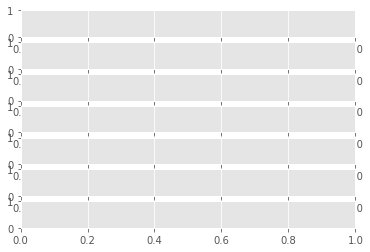

In [0]:
dfig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, ncols=1, sharey=True)
fig.set_figheight(7.5*7)
fig.set_figwidth(15)
ax1.plot(long_sp500_merged['return'], '-', label='long-only');
ax1.plot(short_sp500_merged['return'], '--', label='short-only');
ax1.plot(long_short_sp500_merged['return'], '-.', label='long-short');
ax1.plot(long_sp500_merged['sp500_return'], ':', label='SP500');
ax1.axhline(0);
ax1.legend();

ax2.plot(long_sp500_merged['return'], '-', label='long-only');
ax2.plot(long_sp500_merged['sp500_return'], '--', label='SP500');
ax2.axhline(0);
ax2.legend();

ax3.plot(short_sp500_merged['return'], '-', label='short-only');
ax3.plot(long_sp500_merged['sp500_return'], '--', label='SP500');
ax3.axhline(0);
ax3.legend();

ax4.plot(long_short_sp500_merged['return'], '-', label='long-short');
ax4.plot(long_sp500_merged['sp500_return'], '--', label='SP500');
ax4.plot();
ax4.axhline(0);
ax4.legend();

ax5.plot(long_short_sp500_merged['return'], '-', label='long-short');
ax5.plot(long_sp500_merged['return'], '--', label='long-only');
ax5.plot();
ax5.axhline(0);
ax5.legend();

ax6.plot(long_short_sp500_merged['return'], '-', label='long-short');
ax6.plot(short_sp500_merged['return'], '--', label='short-only');
ax6.plot();
ax6.axhline(0);
ax6.legend();

ax7.plot(long_sp500_merged['return'], '-', label='long-only');
ax7.plot(short_sp500_merged['return'], '--', label='short-only');
ax7.plot();
ax7.axhline(0);
ax7.legend();
ax1.set_title('Performance Comparison (Test: 2013-2018)');

In [0]:
print('Pearson Correlation')
test_port_corr = \
pd.DataFrame([long_sp500_merged['return'], 
              short_sp500_merged['return'], 
              long_short_sp500_merged['return'], 
              long_sp500_merged['sp500_return']], 
             index=['Long', 'Short', 'Long/Short', 'S&P500']).T.corr()
test_port_corr

Pearson Correlation


Long     Short  Long/Short    S&P500
Long        1.000000 -0.805178    0.225035  0.914049
Short      -0.805178  1.000000    0.396629 -0.815895
Long/Short  0.225035  0.396629    1.000000  0.074381
S&P500      0.914049 -0.815895    0.074381  1.000000

In [0]:
test_port_corr.loc['Long', 'S&P500'] * long_sp500_merged['return'].std() / long_sp500_merged['sp500_return'].std()

1.1847410087833672

In [0]:
long_sp500_merged['cum_return'] = long_sp500_merged['return'].cumsum()
short_sp500_merged['cum_return'] = short_sp500_merged['return'].cumsum()
long_short_sp500_merged['cum_return'] = long_short_sp500_merged['return'].cumsum()
long_sp500_merged['sp500_cum_return'] = long_sp500_merged['sp500_return'].cumsum()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


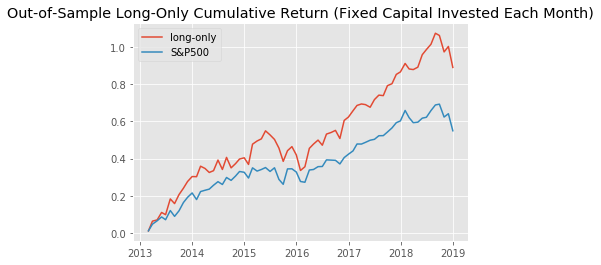

In [0]:
plt.plot(long_sp500_merged['cum_return'], label='long-only')
# plt.plot(short_sp500_merged['cum_return'], label='short-only')
# plt.plot(long_short_sp500_merged['cum_return'], label='long-short')
plt.plot(long_sp500_merged['sp500_cum_return'], label='S&P500')
plt.legend()
plt.title('Out-of-Sample Long-Only Cumulative Return (Fixed Capital Invested Each Month)')
plt.show()

In [0]:
iterations = [10, 100, 1000, 5000, 10000]

In [0]:
iter_sr = {}
for iteration in iterations:
    clf = fit_model('QueryRMSE', {'iterations': iteration, 'task_type': 'GPU'})
    y_test_hat = clf.predict(test_pool)
    y_test_hat = pd.DataFrame(y_test_hat, columns=['score'], index=X_test.index)
    y_test_hat.insert(0, 'PERMNO', X_test['PERMNO'])
    y_test_hat.insert(2, 'y', y_test.values)

    ## Generate Portfolio
    test_long_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(100))
    test_long_portfolio = test_long_portfolio.reset_index(level=1, drop=True)
    test_short_portfolio = y_test_hat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(100))
    test_short_portfolio = test_short_portfolio.reset_index(level=1, drop=True)    
    
    test_long_portfolio_copy = test_long_portfolio.copy()
    test_long_portfolio_copy = test_long_portfolio_copy.reset_index()
    test_long_portfolio_copy = test_long_portfolio_copy.set_index(['date', 'PERMNO'])
    testing_returns = pd.DataFrame(testing_set[['TICKER', 'RET_shifted']])
    testing_returns = testing_returns.reset_index(level=1)
    testing_returns['PERMNO'] = testing_returns['PERMNO'].astype('category')
    test_long_portfolio_merged = pd.merge(test_long_portfolio_copy, testing_returns, how='left', on=['date', 'PERMNO'])
    test_long_portfolio_merged = test_long_portfolio_merged[['PERMNO', 'TICKER', 'RET_shifted']]
    test_long_portfolio_merged = test_long_portfolio_merged.reset_index()
    test_long_portfolio_merged = test_long_portfolio_merged.set_index(['date', 'PERMNO'])    
    
    test_short_portfolio_copy = test_short_portfolio.copy()
    test_short_portfolio_copy = test_short_portfolio_copy.reset_index()
    test_short_portfolio_copy = test_short_portfolio_copy.set_index(['date', 'PERMNO'])
    test_short_portfolio_merged = pd.merge(test_short_portfolio_copy, testing_returns, how='left', on=['date', 'PERMNO'])
    test_short_portfolio_merged = test_short_portfolio_merged[['PERMNO', 'TICKER', 'RET_shifted']]
    test_short_portfolio_merged = test_short_portfolio_merged.reset_index()
    test_short_portfolio_merged = test_short_portfolio_merged.set_index(['date', 'PERMNO']) 
    
    test_long_return = pd.DataFrame(test_long_portfolio_merged.groupby(level=0)['RET_shifted'].mean())
    test_short_return = -pd.DataFrame(test_short_portfolio_merged.groupby(level=0)['RET_shifted'].mean())    
    test_long_short_return = (test_long_return+test_short_return) / 2
    
    test_long_short_sr = test_long_short_return.mean()*np.sqrt(12) / test_long_short_return.std()
    test_long_sr = test_long_return.mean()*np.sqrt(12) / test_long_return.std()
    iter_sr[iteration] = {}
    iter_sr[iteration]['long'] = test_long_sr[0]
    iter_sr[iteration]['long_short'] = test_long_short_sr[0]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7533255	test: 0.7231726	best: 0.7231726 (0)	total: 29.5ms	remaining: 265ms
9:	learn: 0.7527896	test: 0.7231658	best: 0.7231474 (2)	total: 303ms	remaining: 0us
bestTest = 0.7231473978
bestIteration = 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7533255	test: 0.7231726	best: 0.7231726 (0)	total: 30.7ms	remaining: 3.04s
10:	learn: 0.7527374	test: 0.7231698	best: 0.7231473 (2)	total: 318ms	remaining: 2.58s
20:	learn: 0.7522717	test: 0.7232565	best: 0.7231473 (2)	total: 533ms	remaining: 2s
30:	learn: 0.7518249	test: 0.7233598	best: 0.7231473 (2)	total: 767ms	remaining: 1.71s
40:	learn: 0.7514786	test: 0.7234559	best: 0.7231473 (2)	total: 956ms	remaining: 1.38s
50:	learn: 0.7511402	test: 0.7235970	best: 0.7231473 (2)	total: 1.15s	remaining: 1.11s
60:	learn: 0.7507729	test: 0.7237078	best: 0.7231473 (2)	total: 1.34s	remaining: 859ms
70:	learn: 0.7504563	test: 0.7238063	best: 0.7231473 (2)	total: 1.53s	remaining: 625ms
80:	learn: 0.7500888	test: 0.7239075	best: 0.7231473 (2)	total: 1.74s	remaining: 408ms
90:	learn: 0.7498168	test: 0.7239951	best: 0.7231473 (2)	total: 1.96s	remaining: 193ms
99:	learn: 0.7495849	test: 0.7241608	best: 0.7231473 (2)	total: 2.13s	remaining: 0us

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7533255	test: 0.7231726	best: 0.7231726 (0)	total: 29.6ms	remaining: 29.6s
10:	learn: 0.7527374	test: 0.7231699	best: 0.7231473 (2)	total: 321ms	remaining: 28.8s
20:	learn: 0.7522716	test: 0.7232565	best: 0.7231473 (2)	total: 541ms	remaining: 25.2s
30:	learn: 0.7518249	test: 0.7233598	best: 0.7231473 (2)	total: 732ms	remaining: 22.9s
40:	learn: 0.7514786	test: 0.7234560	best: 0.7231473 (2)	total: 920ms	remaining: 21.5s
50:	learn: 0.7511403	test: 0.7235969	best: 0.7231473 (2)	total: 1.13s	remaining: 21s
60:	learn: 0.7507730	test: 0.7237077	best: 0.7231473 (2)	total: 1.32s	remaining: 20.3s
70:	learn: 0.7504562	test: 0.7238063	best: 0.7231473 (2)	total: 1.5s	remaining: 19.6s
80:	learn: 0.7500888	test: 0.7239075	best: 0.7231473 (2)	total: 1.71s	remaining: 19.4s
90:	learn: 0.7498168	test: 0.7239951	best: 0.7231473 (2)	total: 1.9s	remaining: 19s
100:	learn: 0.7495689	test: 0.7241899	best: 0.7231473 (2)	total: 2.1s	remaining: 18.7s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7533255	test: 0.7231726	best: 0.7231726 (0)	total: 28.3ms	remaining: 2m 21s
10:	learn: 0.7527374	test: 0.7231698	best: 0.7231473 (2)	total: 295ms	remaining: 2m 13s
20:	learn: 0.7522717	test: 0.7232565	best: 0.7231473 (2)	total: 486ms	remaining: 1m 55s
30:	learn: 0.7518249	test: 0.7233598	best: 0.7231473 (2)	total: 683ms	remaining: 1m 49s
40:	learn: 0.7514786	test: 0.7234560	best: 0.7231473 (2)	total: 852ms	remaining: 1m 43s
50:	learn: 0.7511402	test: 0.7235969	best: 0.7231473 (2)	total: 1.03s	remaining: 1m 40s
60:	learn: 0.7507730	test: 0.7237077	best: 0.7231473 (2)	total: 1.2s	remaining: 1m 37s
70:	learn: 0.7504563	test: 0.7238063	best: 0.7231473 (2)	total: 1.37s	remaining: 1m 35s
80:	learn: 0.7500889	test: 0.7239074	best: 0.7231473 (2)	total: 1.54s	remaining: 1m 33s
90:	learn: 0.7498168	test: 0.7239951	best: 0.7231473 (2)	total: 1.75s	remaining: 1m 34s
100:	learn: 0.7495690	test: 0.7241899	best: 0.7231473 (2)	total: 1.93s	r

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7533255	test: 0.7231726	best: 0.7231726 (0)	total: 29.6ms	remaining: 4m 56s
10:	learn: 0.7527373	test: 0.7231698	best: 0.7231473 (2)	total: 318ms	remaining: 4m 49s
20:	learn: 0.7522716	test: 0.7232565	best: 0.7231473 (2)	total: 532ms	remaining: 4m 12s
30:	learn: 0.7518249	test: 0.7233598	best: 0.7231473 (2)	total: 729ms	remaining: 3m 54s
40:	learn: 0.7514786	test: 0.7234560	best: 0.7231473 (2)	total: 917ms	remaining: 3m 42s
50:	learn: 0.7511402	test: 0.7235970	best: 0.7231473 (2)	total: 1.13s	remaining: 3m 41s
60:	learn: 0.7507730	test: 0.7237077	best: 0.7231473 (2)	total: 1.35s	remaining: 3m 39s
70:	learn: 0.7504563	test: 0.7238063	best: 0.7231473 (2)	total: 1.53s	remaining: 3m 33s
80:	learn: 0.7500888	test: 0.7239075	best: 0.7231473 (2)	total: 1.74s	remaining: 3m 33s
90:	learn: 0.7498168	test: 0.7239951	best: 0.7231473 (2)	total: 1.94s	remaining: 3m 31s
100:	learn: 0.7495690	test: 0.7241899	best: 0.7231473 (2)	total: 2.12s	

KeyboardInterrupt: ignored

In [0]:
iter_sr

{10: {'long': 0.8951216944501534, 'long_short': 0.1953719616707493},
 100: {'long': 0.9327760338099008, 'long_short': -0.03066259803370737},
 1000: {'long': 0.932727425570374, 'long_short': 0.04647373203246942},
 5000: {'long': 0.851804836788785, 'long_short': -0.052204035527691144}}

In [0]:
pd.DataFrame(iter_sr).T

long  long_short
10    0.895122    0.195372
100   0.932776   -0.030663
1000  0.932727    0.046474
5000  0.851805   -0.052204

In [0]:
sr_df = pd.DataFrame(iter_sr).T

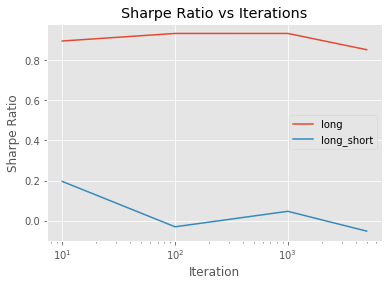

In [0]:
plt.plot(iterations[:-1], sr_df['long'], label='long')
plt.plot(iterations[:-1], sr_df['long_short'], label='long_short')
plt.legend()
plt.title('Sharpe Ratio vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Sharpe Ratio')
plt.xscale('log')